# HFVQE

Este es un notebook para programar HFVQE. El código original está en la librería CIRQ de Google, este es un código simplificado con el objetivo de ser más fácil de leer.

- Artículo original: https://doi.org/10.1126/science.abb9811
- Tutorial: https://quantumai.google/cirq/experiments/hfvqe/quickstart

Importamos librerías

In [1]:
import numpy as np
import scipy as sp
from copy import deepcopy

import cirq
from cirq.contrib.svg import SVGCircuit

## Givens

Antes de comenzar, necesitamos definir funciones para la descomposición de Givens.

**Definimos la rotación de Givens para dos elementos.**

Dado un vector de dos elementos, $v = \begin{pmatrix} a \\ b \end{pmatrix}$, la rotación de Givens proporciona una matriz 2x2 tal que (asumiendo $a$ y $b$ reales) y $p = \text{sign}(a) \text{sign(b)}$:
- Left: $G \times \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} 0 \\ r \end{pmatrix}$, con $G = \frac{1}{\sqrt{a^2+b^2}} \begin{pmatrix} |b| & -p|a| \\ p|a| & |b| \end{pmatrix} = \begin{pmatrix} \cos \theta & -p\sin \theta \\ p\sin \theta & \cos \theta \end{pmatrix}$

G es la matriz de Rotación que gira el vector $v$ y lo alinea en Y si está en el cuadrante (I y II) y -Y si está en el cuadrante (III y IV).

- Right: $G \times \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} r \\ 0 \end{pmatrix}$, con $G = \frac{1}{\sqrt{a^2+b^2}} \begin{pmatrix} |a| & p|b| \\ -p|b| & |a| \end{pmatrix} = \begin{pmatrix} \sin \theta & p\cos \theta \\ -p\cos \theta & \sin \theta \end{pmatrix}$

G es la matriz de Rotación que gira el vector $v$ y lo alinea en X si está en el cuadrante (I y III) y -X si está en el cuadrante (II y IV).

Si $a$ y $b$ son reales, entonces $r_\text{left}=\text{sign}(b)\sqrt{a^2 + b^2}$ y $r_\text{right}=\text{sign}(a)\sqrt{a^2 + b^2}$.

In [2]:
# Versión simplificada de openfermion.linalg.givens_rotations.givens_matrix_elements
def givens_matrix_elements(a, b, which='left'):
    # Handle case that a is zero
    if abs(a) < EQ_TOLERANCE:
        cosine = 1.0
        sine = 0.0
        phase = 1.0
    # Handle case that b is zero and a is nonzero
    elif abs(b) < EQ_TOLERANCE:
        cosine = 0.0
        sine = 1.0
        phase = 1.0
    # Handle case that a and b are both nonzero
    else:
        denominator = np.sqrt(abs(a) ** 2 + abs(b) ** 2)
        cosine = abs(b) / denominator
        sine = abs(a) / denominator
        sign_b = np.sign(b)
        sign_a = np.sign(a)
        phase = sign_a * sign_b.conjugate()

    if which == 'left':
        givens_rotation = np.array([[cosine, -phase * sine], [phase * sine, cosine]])
    elif which == 'right':
        givens_rotation = np.array([[sine, phase * cosine], [-phase * cosine, sine]])
    return givens_rotation

**Definimos como aplicar la rotación dentro de una matriz más grande**.

Dada la matriz de Givens asociada a la rotación:
\begin{equation}
M = \begin{pmatrix}
1      & \cdots & 0      & 0      & \cdots & 0\\
\vdots & 1 & \vdots & \vdots & \ddots & \vdots\\
0      & \cdots & G_{11} & G_{12} & \cdots & 0\\
0      & \cdots & G_{21} & G_{22} & \cdots & 0\\
\vdots & \ddots & \vdots & \vdots & 1 & \vdots\\
0      & \cdots & 0      & 0      & \cdots & 1\\
\end{pmatrix}
\end{equation}
y una matriz $O$, el siguiente código aplica la operación:
- "Row": $M \times O$
- "Column": $O \times M^T$

In [3]:
def givens_rotate(operator, givens_rotation, i, j, which='row'):
    if which == 'row':
        # Rotate rows i and j
        row_i = operator[i].copy()
        row_j = operator[j].copy()
        operator[i] = givens_rotation[0, 0] * row_i + givens_rotation[0, 1] * row_j
        operator[j] = givens_rotation[1, 0] * row_i + givens_rotation[1, 1] * row_j
    elif which == 'col':
        # Rotate columns i and j
        col_i = operator[:, i].copy()
        col_j = operator[:, j].copy()
        operator[:, i] = givens_rotation[0, 0] * col_i + givens_rotation[0, 1].conj() * col_j
        operator[:, j] = givens_rotation[1, 0] * col_i + givens_rotation[1, 1].conj() * col_j

**La siguiente función aplica la descomposición de Givens.**

Dada una matriz $Q$, se generan matrices $V$, $U$ y $D$ tal que:
\begin{equation}
    V_{(m \times m)} Q_{(m \times n)} U{(n \times n)}^\dagger = D_{(m \times n)}
\end{equation}

- $Q$ tiene renglones ortonormales ($m \leq n$)
- $V$ es una matriz unitaria
- $U$ es una matriz unitaria
- $D$ es una matriz diagonal. Las primeras $m$-columnas forman la matriz diagonal, y lo demás es cero.

La matriz $U$ se expresa como $U = G_k \cdots G_1$

La primera etapa construye la $V$. Comienza en la esquina superior derecha de la matriz (primer renglón, última columna), y aplica rotaciones de Givens (right y rows) para mover los elementos de los renglones de arriba hacia abajo hasta la diagonal, luego procede a la columna de la izquierda. Esto sucede en el bloque de $m$ renglones y $m-1$ columnas del extremo derecho. Aplica las mismas rotaciones a la matriz identidad y genera la $V$.

La segunda parte consiste en construir la matriz $D$ y generar las rotaciones de Givens de $U$ que se usarán en las Quantum Gates. Consiste en tres partes:
- 1 Inicia en el renglón $0$ y columna $n-m$ y aplica Rotaciones de Givens para mover los elementos de las columnas hacia la izquierda. En cada iteración, te colocas en el renglón cero y mueves una diagonal hasta que se acaben columnas o renglones. El límite lo establece qué se acaba primero, las $n-m$ columnas (movimiento horizontal) o los $m$ renglones (movimiento vertical).
- 2a \[Se acaban primero los $m$ renglones por abajo ($m < n-m$)\], entonces continúa moviendo diagonales de derecha a izquierda sin agregar nuevos renglones (porque ya se acabaron) hasta que se acaben las columnas por la izquierda. (Cuando se acaban los renglones por abajo, también se acaban las columnas por la derecha.)
- 2b \[Si se acaban primero las $n-m$ columnas por la izquierda ($n-m < m$)\], entonces continúa moviendo las diagonales de derecha a izquierda, agregando nuevos renglones pero desplazando el inicio hacia abajo, ya que se acabaron las columnas.
- 3 Una vez que se hayan acabado los renglones y columnas, entonces termina de mover lo que falte para hacer la matriz diagonal.

*Nota.* 1 no da el último paso, sino que se detiene cuando falta el último renglón/columna y transfiere el control a 2a/b para que hagan cero el último elemento. 2a/b sí dan el último paso de hacer cero el último elemento de columna/renglón y transfieren el control a 3.
Nota. Con mover la diagonal me refiero a las diagonales que se forman a partir del elemento inicial, no a la diagonal principal.

Las quantum gates que se pueden hacer de manera simultánea corresponden a los elementos de la diagonal que se mueven en la misma iteración $k$.

In [4]:
def givens_decomposition(unitary_rows, always_insert=False):
    current_matrix = np.copy(unitary_rows)
    m, n = current_matrix.shape

    # Primera etapa: Genera la matriz V
    V = np.eye(m, dtype=complex)
    for k in reversed(range(n - m + 1, n)):
        for l in range(m - n + k):
            givens_rotation = givens_matrix_elements(current_matrix[l, k], current_matrix[l + 1, k])
            # Apply Givens rotation
            givens_rotate(current_matrix, givens_rotation, l, l + 1)
            givens_rotate(V, givens_rotation, l, l + 1)

    # Segunda etapa: Genera la matriz D y las rotaciones de Givens para U.
    givens_rotations = []
    # If m = n (the matrix is square) then we don't need to perform any Givens rotations!
    if m != n:
        # Get the maximum number of simultaneous rotations that will be performed
        max_simul_rotations = min(m, n - m)
        # There are n - 1 iterations (the circuit depth is n - 1)
        for k in range(n - 1):
            # Get the (row, column) indices of elements to zero out in parallel.
            if k < max_simul_rotations - 1:
                # There are k + 1 elements to zero out
                start_row = 0
                end_row = k + 1
                start_column = n - m - k
                end_column = start_column + 2 * (k + 1)
            elif k > n - 1 - max_simul_rotations:
                # There are n - 1 - k elements to zero out
                start_row = m - (n - 1 - k)
                end_row = m
                start_column = m - (n - 1 - k) + 1
                end_column = start_column + 2 * (n - 1 - k)
            else:
                # There are max_simul_rotations elements to zero out
                if max_simul_rotations == m:
                    start_row = 0
                    end_row = m
                    start_column = n - m - k
                    end_column = start_column + 2 * m
                else:
                    start_row = k + 1 - max_simul_rotations
                    end_row = k + 1
                    start_column = k + 1 - max_simul_rotations + 1
                    end_column = start_column + 2 * max_simul_rotations

            row_indices = range(start_row, end_row)
            column_indices = range(start_column, end_column, 2)
            indices_to_zero_out = zip(row_indices, column_indices)

            parallel_rotations = []
            for i, j in indices_to_zero_out:
                # Compute the Givens rotation to zero out the (i, j) element, if needed
                right_element = current_matrix[i, j].conj()
                if always_insert or abs(right_element) > EQ_TOLERANCE:
                    # We actually need to perform a Givens rotation
                    left_element = current_matrix[i, j - 1].conj()
                    givens_rotation = givens_matrix_elements(
                        left_element, right_element, which='right'
                    )

                    # Add the parameters to the list
                    theta = np.arcsin(np.real(givens_rotation[1, 0]))
                    parallel_rotations.append((j - 1, j, theta, 0))

                    # Update the matrix
                    givens_rotate(current_matrix, givens_rotation, j - 1, j, which='col')

            # If the current list of parallel operations is not empty, append it to the list,
            if parallel_rotations:
                givens_rotations.append(tuple(parallel_rotations))

    # Get the diagonal entries
    diagonal = current_matrix.diagonal()
    
    return givens_rotations, V, diagonal

## HFVQE: Cálculo de energía a parámetros fijos. 



**A continuación definimos una molécula y sus integrales en orbital molecular.**

In [5]:
import pyscf
mol = pyscf.gto.M(atom = """
  H    0.0000000    0.0000000   0
  H    0.0000000    0.0000000   1.3
  H    0.0000000    0.0000000   2.6
  H    0.0000000    0.0000000   3.9
  H    0.0000000    0.0000000   5.2
  H    0.0000000    0.0000000   6.5
""", basis = 'sto-3g')

S = mol.intor("int1e_ovlp")
T = mol.intor_symmetric('int1e_kin')
V = mol.intor_symmetric('int1e_nuc')
Hcore = T + V

I = mol.intor('int2e', aosym=1)

e,C = sp.linalg.eigh(Hcore, S)

H_MO = np.einsum("mn,mi,nj->ij",Hcore, C, C, optimize=True)
I_MO = np.einsum("mnsl,mi,nj,sk,lt->ijkt", I, C, C, C, C, optimize=True)
I_MO = np.einsum('psqr->pqrs', I_MO, optimize=True) #Notación física de integrales

**Declaramos variables** (Restricted Case)

In [6]:
n_orbitals = np.shape(H_MO)[0]
n_qubits = n_orbitals

n_electrons = mol.nelectron
nocc = n_electrons // 2
nvirt = n_orbitals - nocc
num_samples = 250000
EQ_TOLERANCE = 10**-8

**Importamos el sistema de seis hidrógenos** separados por 1.3 Angstroms para usar los mismos parámetros iniciales que lo reportado en ReCirq por fines comparativos. Todo lo demás (obi y tbi) ya está arriba. Podríamos no hacer este paso y usar parámetros iniciales aleatorios.

*Nota.* Por dentro, Cirq hace una minimización clásica de los parámetros con scipy.optimize.

In [7]:
from recirq.hfvqe.molecular_example import make_h6_1_3
rhf_objective, molecule, parameters, obi, tbi = make_h6_1_3()

Optimization terminated successfully.
         Current function value: -2.924060
         Iterations: 7
         Function evaluations: 15
         Gradient evaluations: 15


**Generamos tantos qubits como orbitales espaciales.**

In [8]:
qubits = [cirq.GridQubit(0, x) for x in range(n_qubits)]
sampler = cirq.Simulator(dtype=np.complex128)

**Generamos la U unitaria para la rotación de HF**

In [9]:
def create_U(parameters):

    Y = np.zeros((n_orbitals, n_orbitals))
    Y[nocc:,:nvirt] = parameters.reshape(nocc,nvirt)
    Y[:nocc,nvirt:] = -np.transpose(parameters.reshape(nocc,nvirt))

    U = sp.linalg.expm(Y)
    return U

U = create_U(parameters)

**Medición de la 1RDM**

La estrategia para medir la 1RDM consiste en mediar la diagonal principal y una diagonal superior e inferior. Los demás elementos se obtienen a partir de permutaciones, tal que los otros elementos queden en la diagonal principal, $\Gamma_{i,i}$, una arriba, $\Gamma_{i,i+1}$, o una abajo, $\Gamma_{i+1,i}$.

*Por ejemplo, 6 orbitales hacen una 1RDM de 6x6, con 3 permutaciones*:
- (0,1,2,3,4,5)
- (1,3,0,5,2,4)
- (3,5,1,4,0,2)

Los elementos diagonales se pueden obtener de cualquier permutación. En general se obtienen de (0,1,2,3,4,5), dando lugar a $\Gamma_{00}$, $\Gamma_{11}$, $\Gamma_{22}$, $\Gamma_{33}$, $\Gamma_{44}$, $\Gamma_{55}$, y los elementos fuera de la diagonal se obtienen como:
- El ordenamiento de orbitales como (0,1,2,3,4,5) proporciona los términos $\Gamma_{0,1}$, $\Gamma_{1,2}$, $\Gamma_{2,3}$, $\Gamma_{3,4}$, $\Gamma_{4,5}$
- El ordenamiento de orbitales como (1,3,0,5,2,4) proporciona los términos $\Gamma_{1,3}$, $\Gamma_{3,0}$, $\Gamma_{0,5}$, $\Gamma_{5,2}$, $\Gamma_{2,4}$
- El ordenamiento de orbitales como (3,5,1,4,0,2) proporciona los términos $\Gamma_{3,5}$, $\Gamma_{5,1}$, $\Gamma_{1,4}$, $\Gamma_{4,0}$, $\Gamma_{0,2}$


Dados $N$ orbitales, necesitamos $N/2$ permutaciones.

In [10]:
def generate_permutations():

    num_permutations = n_qubits//2
    permutations = []
    permuted_indeces = []
    for i in range(num_permutations):
        # Generate permutation list
        swap_depth = 2*i
        swap_list = []
        indeces = list(range(n_qubits))
        for i in range(0, swap_depth):
            if i % 2 == 0:
                swap_list.append([(i, i + 1) for i in range(0, n_qubits - 1, 2)])
            else:
                swap_list.append([(i, i + 1) for i in range(1, n_qubits - 1, 2)])
        permutations.append(swap_list)
        for i in range(0, swap_depth):
            for j,k in swap_list[i]:
                indeces[j], indeces[k] = indeces[k], indeces[j]
        permuted_indeces.append(indeces)

    return permutations, permuted_indeces

permutations, permuted_indeces = generate_permutations()

**Generamos la U para cada permutación**

In [11]:
def generate_permuted_matrices(permutations,U):
    
    permuted_matrices = []
    for swap_list in permutations:
        # Generate swap unitaries
        swap_unitaries = []
        for swap_tuples in swap_list:
            generator = np.zeros((n_qubits, n_qubits), dtype=np.complex128)
            for i, j in swap_tuples:
                generator[i, i] = -1
                generator[j, j] = -1
                generator[i, j] = 1
                generator[j, i] = 1
            swap_unitaries.append(sp.linalg.expm(-1j * np.pi * generator / 2))

        shifted_unitary = U.copy()
        for uu in swap_unitaries:
            shifted_unitary = uu @ shifted_unitary
        matrix = shifted_unitary.T[:nocc, :]
        permuted_matrices.append(matrix)

    return permuted_matrices

permuted_matrices = generate_permuted_matrices(permutations,U)

**Generamos el circuito de preparación del sistema para cada permutación**

In [12]:
def generate_permuted_circuits(permuted_matrices,qubits):
    circuits = [] # un circuito por permutación
    for matrix in permuted_matrices:
        permuted_circuit = cirq.Circuit()
        decomposition,_,_ = givens_decomposition(matrix)
    
        circuit_description = list(reversed(decomposition))

        # Initialize occupied orbitals
        for j in range(matrix.shape[0]):
            permuted_circuit += cirq.X(qubits[j])
    
        for parallel_ops in circuit_description:
            for op in parallel_ops:
                i, j, theta, phi = op
                
                #ryxxy(qubits[i], qubits[j], theta)
                a = qubits[i]
                b = qubits[j]
                permuted_circuit += cirq.ISWAP.on(a, b)**0.5
                permuted_circuit += cirq.rz(-theta + np.pi).on(a)
                permuted_circuit += cirq.rz(theta).on(b)
                permuted_circuit += cirq.ISWAP.on(a, b)**0.5
                permuted_circuit += cirq.rz(np.pi).on(a)
        circuits.append(permuted_circuit)
    return circuits
circuits = generate_permuted_circuits(permuted_matrices,qubits)

**Visualizamos un circuito para revisar que todo salió bien.** (En este ejemplo hay 3 circuitos, porque hay 3 permutaciones).

Cada circuito prepara el determinante de Slater dado un conjunto de parámetros que producen la rotación. Notar que todavía no hay mediciones en el circuito.

Podemos visualizar:
```
SVGCircuit(circuits[0])
SVGCircuit(circuits[1])
SVGCircuit(circuits[2])
```

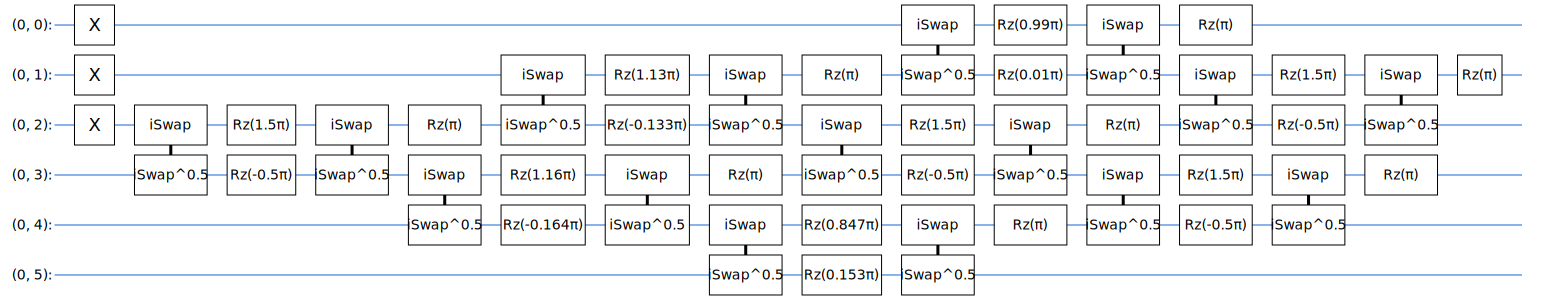

In [13]:
SVGCircuit(circuits[0])

**Tomamos los 3 circuitos anteriores, y les agregamos Gates para medir** el valor esperado de Z en cada qubit. Además, al aplicar rotaciones en Z, se diagonaliza la representación de XX + YY, y podemos medir en la base computacional y calcular los elementos que necesitamos como diferencias de Z.

In [14]:
def generate_measurment_circuits(qubits,circuits):
    # Pares de qubits
    even_pairs = [qubits[idx:idx + 2] for idx in np.arange(0, n_qubits - 1, 2)]
    odd_pairs  = [qubits[idx:idx + 2] for idx in np.arange(1, n_qubits - 1, 2)]
    
    # Diccionario con los circuitos para las cantidades a medir
    measure_labels = ['z', 'xy_even', 'xy_odd']
    all_circuits_with_measurements = {label: {} for label in measure_labels}
    for circuit_index in range(len(circuits)):
        for _, label in enumerate(measure_labels):
            circuit = deepcopy(circuits[circuit_index])
            if label == 'xy_even':
                all_ops = []
                for a, b in even_pairs: 
                    all_ops += [
                        cirq.rz(-np.pi * 0.25).on(a),
                        cirq.rz(np.pi * 0.25).on(b),
                        cirq.ISWAP.on(a, b)**0.5
                    ]
                circuit.append(all_ops,strategy=cirq.InsertStrategy.EARLIEST)
            if label == 'xy_odd':
                all_ops = []
                for a, b in odd_pairs: 
                    all_ops += [
                        cirq.rz(-np.pi * 0.25).on(a),
                        cirq.rz(np.pi * 0.25).on(b),
                        cirq.ISWAP.on(a, b)**0.5
                    ]
                circuit.append(all_ops,strategy=cirq.InsertStrategy.EARLIEST)
            circuit.append(cirq.Moment([cirq.measure(q) for q in qubits]))
            all_circuits_with_measurements[label][circuit_index] = circuit
    circuits_dict = all_circuits_with_measurements
    
    return circuits_dict
    
circuits_dict = generate_measurment_circuits(qubits,circuits)

**Visualizamos un circuito con medición**, por ejemplo, el de Z para la permutación 0. También tenemos:
```
SVGCircuit(circuits_dict["z"][0])
SVGCircuit(circuits_dict["xy_even"][0])
SVGCircuit(circuits_dict["xy_odd"][0])
```

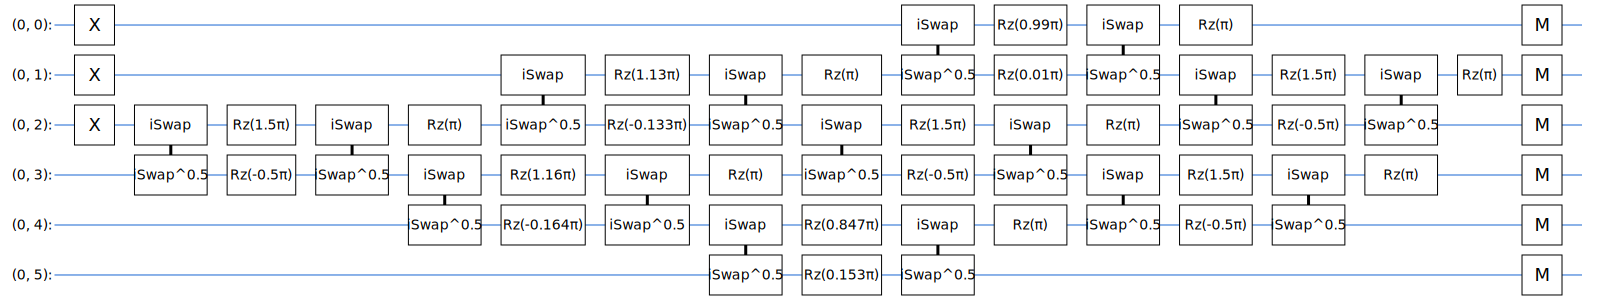

In [15]:
SVGCircuit(circuits_dict["z"][0])

**Llevamos a cabo las mediciones.** La post-selection descarta las 1RDM cuya diagonal no sume N/2. Quité la corrección de errores por purificación de la 1RDM.

In [16]:
def perform_measurments(qubits,permuted_indeces,circuits,circuits_dict):
    # Diccionario con los resultados de las mediciones
    post_selection = True
    data_dict = {
        'z': {},
        'xy_even': {},
        'xy_odd': {},
        'qubits': [str(q) for q in qubits],
        'qubit_permutations': permuted_indeces,
        'circuits': circuits,
        'circuits_with_measurement': circuits_dict
    }
    for measure_type in circuits_dict.keys():
        circuits = circuits_dict[measure_type]
        for circuit_index in circuits.keys():
            circuit = circuits[circuit_index]
            data = sampler.run(circuit, repetitions=num_samples)
            if post_selection:
                good_indices = np.where(np.sum(np.array(data.data), axis=1) == n_electrons/2)[0]
                good_data = data.data[data.data.index.isin(good_indices)]
                data_dict[measure_type][circuit_index] = good_data
            else:
                data_dict[measure_type][circuit_index] = data.data
    return data_dict
data_dict = perform_measurments(qubits,permuted_indeces,circuits,circuits_dict)

**Visualizamos el dataframe con las mediciones**

data_dict es un diccionario de Pandas Dataframe con los resultados de las mediciones en la base computacional de los qubits tras ejecutar los circuitos Z, XY even y XY odd.

In [17]:
data_dict["z"][0]

,"q(0, 0)","q(0, 1)","q(0, 2)","q(0, 3)","q(0, 4)","q(0, 5)"
0,1,0,1,1,0,0
1,1,0,1,1,0,0
2,1,1,1,0,0,0
3,1,1,1,0,0,0
4,1,1,1,0,0,0
...,...,...,...,...,...,...
249995,1,1,1,0,0,0
249996,1,1,1,0,0,0
249997,1,1,1,0,0,0
249998,1,1,1,0,0,0


**Construimos la OPDM a partir de las mediciones.**

$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\expval}[1]{\left\langle{#1}\right\rangle}$$

- Para mediar la diagonal de la 1RDM

$\expval{a_i^\dagger a_i} = \frac{I - \expval{Z_i}}{2} = \expval{M_i}$

- Para medir los elementos fuera de la diagonal de la 1RDM

$\expval{a_i^\dagger a_{i+1} + a_{i+1}^\dagger a_i} = \frac{1}{2} (\expval{X_i X_{i+1}} + \expval{Y_i Y_{i+1}}) = 2R\expval{a_i^\dagger a_{i+1}}$

con el cambio de base apropiado:

$\bra{U_m} a_i^\dagger a_{i+1} + a_{i+1}^\dagger a_i \ket{U_m} = \frac{1}{2} \expval{Z_i - Z_{i+1}} = \frac{1}{2} (M_{i+1} - M_{i})$

In [18]:
def build_opdm(data_dict,n_qubits):

    qubits_str = data_dict['qubits']
    opdm = np.zeros((n_qubits, n_qubits))
    variance_dict = {'xy_even': {}, 'xy_odd': {}, 'z': {}}

    results_dict = data_dict
    for circuit_idx, permutation in enumerate(results_dict['qubit_permutations']):
        for pair_idx in range(n_qubits - 1):
            if pair_idx % 2 == 0:
                data = results_dict['xy_even'][circuit_idx]
            else:
                data = results_dict['xy_odd'][circuit_idx]
            q0, q1 = qubits_str[pair_idx:pair_idx + 2]
            qA, qB = permutation[pair_idx:pair_idx + 2]
            # 1RDM: elementos fuera de la diagonal \frac{1}{2} (M_{i+1} - M_{i})
            opdm[qA, qB] += np.mean(data[q1] - data[q0], axis=0) * 0.5
            opdm[qB, qA] += np.mean(data[q1] - data[q0], axis=0) * 0.5
        
        if circuit_idx == 0:  # No re-ordering
            for qubit_idx, q in enumerate(qubits_str):
                data = results_dict['z'][circuit_idx][q]
                # 1RDM: elementos diagonales \expval{a_i^\dagger a_{i}} = M_{i}
                opdm[qubit_idx, qubit_idx] = np.mean(data, axis=0)

    return opdm
    
opdm = build_opdm(data_dict,n_qubits)

**Reconstruimos la 2RDM a partir de la 1RDM**. Aquí se utiliza la reconstrucción de Hartree-Fock en orbitales de espín.

In [19]:
def build_spin_opdm_tpdm(opdm):
    spin_opdm = np.kron(opdm, np.eye(2))
    spin_tpdm = np.einsum("pi,qj->pqji",spin_opdm,spin_opdm,optimize=True) - np.einsum("qi,pj->pqji",spin_opdm,spin_opdm,optimize=True)
    return spin_opdm, spin_tpdm
spin_opdm, spin_tpdm = build_spin_opdm_tpdm(opdm)

**Transformamos las integrales a orbital de espín**

In [20]:
def spin_integrals(H_MO,I_MO):
    obi = H_MO
    tbi = I_MO
    spin_obi = np.zeros((2*n_orbitals, 2*n_orbitals))
    spin_tbi = np.zeros((2*n_orbitals, 2*n_orbitals, 2*n_orbitals, 2*n_orbitals))
    # Loop through integrals.
    for p in range(n_orbitals):
        for q in range(n_orbitals):
            # Populate 1-body coefficients. Require p and q have same spin.
            spin_obi[2 * p, 2 * q] = obi[p, q]
            spin_obi[2 * p + 1, 2 * q + 1] = obi[p, q]
            # Continue looping to prepare 2-body coefficients.
            for r in range(n_orbitals):
                for s in range(n_orbitals):
                    # Mixed spin
                    spin_tbi[2 * p, 2 * q + 1, 2 * r + 1, 2 * s] = tbi[p, q, r, s] / 2.
                    spin_tbi[2 * p + 1, 2 * q, 2 * r, 2 * s + 1] = tbi[p, q, r, s] / 2.
                    # Same spin
                    spin_tbi[2 * p, 2 * q, 2 * r, 2 * s] = tbi[p, q, r, s] / 2.
                    spin_tbi[2 * p + 1, 2 * q + 1, 2 * r + 1, 2 * s + 1] = tbi[p, q, r, s] / 2.
    return spin_obi, spin_tbi
spin_obi, spin_tbi = spin_integrals(H_MO,I_MO)

**Calculamos la energía**

In [21]:
def Energy(Enuc, spin_obi, spin_tbi, spin_opdm, spin_tpdm):
    E = Enuc
    E += np.sum(spin_obi * spin_opdm)
    E += np.sum(spin_tbi * spin_tpdm)
    return E

E = Energy(mol.energy_nuc(), spin_obi, spin_tbi, spin_opdm, spin_tpdm)
E

-2.925434962461636

## HFVQE: Optimización de parámetros para minimizar de la energía

**Definimos funciones para el gradiente y el Hessiano**

In [22]:
def rot_gen_HF():
    # esta es una muy rebuscada forma de generar a_p^\dagger a_q - a_q^\dagger a_p
    rotation_generators = []
    for p in range(nocc * nvirt):
        grad_params = np.zeros(rhf_objective.nocc * rhf_objective.nvirt)
        grad_params[p] = 1

        Y_spatial = np.zeros((n_orbitals, n_orbitals))
        Y_spatial[nocc:,:nvirt] = grad_params.reshape(nocc,nvirt)
        Y_spatial[:nocc,nvirt:] = -np.transpose(grad_params.reshape(nocc,nvirt))

        p0 = np.array([[1, 0], [0, 1]])
        Y_spin = np.kron(Y_spatial, p0)
        rotation_generators.append(Y_spin)
    return rotation_generators

def derivatives1_HF(spin_obi, spin_opdm, spin_tbi, spin_tpdm, rotation_generators):
    gradient = np.zeros(nocc * nvirt)
    for idx,rot_gen_tensor in enumerate(rotation_generators):
        Id = np.eye(2*n_orbitals)

        commutator_expectation = 0
        #   (  -1.00000) Id(i,q) cre(p) des(j)
        commutator_expectation += -1.0 * np.einsum('ij,pq,iq,pj', spin_obi, rot_gen_tensor, Id, spin_opdm, optimize=True)
        #   (   1.00000) Id(j,p) cre(i) des(q)
        commutator_expectation +=  1.0 * np.einsum('ij,pq,jp,iq',  spin_obi, rot_gen_tensor, Id, spin_opdm, optimize=True)
        #   (   1.00000) Id(i,q) cre(j) cre(p) des(k) des(l)
        commutator_expectation +=  1.0 * np.einsum('ijkl,pq,iq,jpkl', spin_tbi, rot_gen_tensor, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(j,q) cre(i) cre(p) des(k) des(l)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,jq,ipkl', spin_tbi, rot_gen_tensor, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(k,p) cre(i) cre(j) des(l) des(q)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,kp,ijlq', spin_tbi, rot_gen_tensor, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(l,p) cre(i) cre(j) des(k) des(q)
        commutator_expectation +=  1.0 * np.einsum('ijkl,pq,lp,ijkq', spin_tbi, rot_gen_tensor, Id, spin_tpdm, optimize=True)

        gradient[idx] = commutator_expectation

    return gradient

def derivatives2_HF(spin_obi, spin_opdm, spin_tbi, spin_tpdm, rotation_generators):
    hessian = np.zeros((nocc * nvirt,nocc * nvirt))
    for (ridx,rgen_tensor),(lidx,sgen_tensor) in zip(enumerate(rotation_generators),enumerate(rotation_generators)):
        Id = np.eye(2*n_orbitals)

        commutator_expectation = 0
        #   (  -1.00000) Id(i,q) Id(j,r) cre(p) des(s)
        commutator_expectation += -1.0 * np.einsum('ij,pq,rs,iq,jr,ps', spin_obi, rgen_tensor, sgen_tensor, Id, Id, spin_opdm, optimize=True)
        #   (   1.00000) Id(i,q) Id(p,s) cre(r) des(j)
        commutator_expectation += 1.0 * np.einsum('ij,pq,rs,iq,ps,rj', spin_obi, rgen_tensor, sgen_tensor, Id, Id, spin_opdm, optimize=True)
        #   (  -1.00000) Id(i,s) Id(j,p) cre(r) des(q)
        commutator_expectation += -1.0 * np.einsum('ij,pq,rs,is,jp,rq', spin_obi, rgen_tensor, sgen_tensor, Id, Id, spin_opdm, optimize=True)
        #   (   1.00000) Id(j,p) Id(q,r) cre(i) des(s)
        commutator_expectation += 1.0 * np.einsum('ij,pq,rs,jp,qr,is', spin_obi, rgen_tensor, sgen_tensor, Id, Id, spin_opdm, optimize=True)

        #   (   1.00000) Id(i,q) Id(j,s) cre(p) cre(r) des(k) des(l)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,iq,js,prkl', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(i,q) Id(k,r) cre(j) cre(p) des(l) des(s)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,iq,kr,jpls', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(i,q) Id(l,r) cre(j) cre(p) des(k) des(s)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,iq,lr,jpks', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(i,q) Id(p,s) cre(j) cre(r) des(k) des(l)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,iq,ps,jrkl', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(i,s) Id(j,q) cre(p) cre(r) des(k) des(l)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,is,jq,prkl', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(i,s) Id(k,p) cre(j) cre(r) des(l) des(q)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,is,kp,jrlq', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(i,s) Id(l,p) cre(j) cre(r) des(k) des(q)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,is,lp,jrkq', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(j,q) Id(k,r) cre(i) cre(p) des(l) des(s)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,jq,kr,ipls', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(j,q) Id(l,r) cre(i) cre(p) des(k) des(s)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,jq,lr,ipks', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(j,q) Id(p,s) cre(i) cre(r) des(k) des(l)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,jq,ps,irkl', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(j,s) Id(k,p) cre(i) cre(r) des(l) des(q)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,js,kp,irlq', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(j,s) Id(l,p) cre(i) cre(r) des(k) des(q)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,js,lp,irkq', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(k,p) Id(l,r) cre(i) cre(j) des(q) des(s)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,kp,lr,ijqs', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(k,p) Id(q,r) cre(i) cre(j) des(l) des(s)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,kp,qr,ijls', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (  -1.00000) Id(k,r) Id(l,p) cre(i) cre(j) des(q) des(s)
        commutator_expectation += -1.0 * np.einsum('ijkl,pq,rs,kr,lp,ijqs', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        #   (   1.00000) Id(l,p) Id(q,r) cre(i) cre(j) des(k) des(s)
        commutator_expectation += 1.0 * np.einsum('ijkl,pq,rs,lp,qr,ijks', spin_tbi, rgen_tensor, sgen_tensor, Id, Id, spin_tpdm, optimize=True)
        hessian[ridx,lidx] = commutator_expectation

    return hessian

**Parámetros para controlar el minimizador**

In [23]:
delta = 0.3
rtol = 0.5E-2
max_iter = 20

**Minimizamos con augmented Hessian.** Podemos usar cualquier minimizador, pero estoy aprovechando el código de Google.

In [24]:
permutations, permuted_indeces = generate_permutations()
fr_vals = parameters + 1.0E-1 #movemos un poco los parámetros óptimos
current_unitary = np.eye(nocc + nvirt)

energies = []
current_count = 0
while current_count < max_iter:

    # Actializa la matriz unitaria
    U_new = create_U(fr_vals) @ current_unitary

    # Genera circuitos de medición
    permuted_matrices = generate_permuted_matrices(permutations, U_new)
    circuits = generate_permuted_circuits(permuted_matrices, qubits)
    circuits_dict = generate_measurment_circuits(qubits, circuits)

    # Mide y construye la 1RDM
    data_dict = perform_measurments(qubits,permuted_indeces, circuits, circuits_dict)
    opdm = build_opdm(data_dict, n_qubits)

    # Calcula energía a partir de la 1RDM
    spin_opdm, spin_tpdm = build_spin_opdm_tpdm(opdm)
    E = Energy(mol.energy_nuc(), spin_obi, spin_tbi, spin_opdm, spin_tpdm)
    energies.append(E)
    print("Iter: {} Energy: {:7.4f}".format(current_count, E))

    # Derivadas y gradiente
    rotation_generators = rot_gen_HF()
    gradient = derivatives1_HF(spin_obi, spin_opdm, spin_tbi, spin_tpdm, rotation_generators)
    hessian = derivatives2_HF(spin_obi, spin_opdm, spin_tbi, spin_tpdm, rotation_generators)

    # build augmented Hessian
    gradient = gradient.reshape((-1, 1))
    aug_hess = np.hstack((np.array([[0]]), gradient.conj().T))
    aug_hess = np.vstack((aug_hess, np.hstack((gradient, hessian))))

    w, v = np.linalg.eig(aug_hess)
    sort_idx = np.argsort(w)
    w = w[sort_idx]
    v = v[:, sort_idx]
    new_fr_vals = v[1:, [0]].flatten() / v[0, 0]
    
    if np.max(abs(new_fr_vals)) >= delta:
        new_fr_vals = delta * new_fr_vals / np.max(abs(new_fr_vals))

    if np.linalg.norm(new_fr_vals) < rtol:
        break
    
    # assign new values to the things being evaluated next iteration
    fr_vals = new_fr_vals.copy()
    current_unitary = U_new.copy()

    current_count += 1 

Iter: 0 Energy: -2.8256
Iter: 1 Energy: -2.9090
Iter: 2 Energy: -2.9201
Iter: 3 Energy: -2.9216
Iter: 4 Energy: -2.9227
Iter: 5 Energy: -2.9239


**Graficamos**

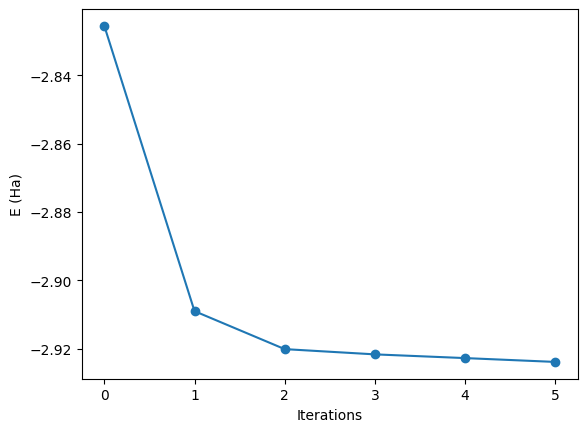

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(energies)), energies)
plt.scatter(range(len(energies)), energies)

plt.xlabel("Iterations")
plt.ylabel("E (Ha)")

plt.show()